Load all images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import skimage
import os
import random
from skimage import data, io, filters

path = '50_categories/'

folders = [f for f in sorted(os.listdir(path))]
images = {}

for i,f in enumerate(folders[2:12]):
    folder_path = path + f +'/'
    key = "cat_" + str(i)
    image_catigory = []
    for file in sorted(os.listdir(folder_path)):
        file_path = folder_path + file
        img=mpimg.imread(file_path)
        image_catigory.append((img,i))
    images[key] = image_catigory
    print("Done with",f)


Done with bat
Done with bear
Done with blimp
Done with camel
Done with comet
Done with conch
Done with cormorant
Done with crab
Done with dog
Done with dolphin
Done with duck
Done with elephant
Done with elk
Done with frog
Done with galaxy
Done with giraffe
Done with goat
Done with goldfish


Look through some of the images

In [3]:
plt.imshow(images['cat_'+str(random.randint(0,49))][random.randint(0,50)][0])
plt.show()

KeyError: 'cat_18'

In [4]:
train_percentage = .9
train_set = []
test_set = []
for key in images:
    imlist = images[key]
    random.shuffle(imlist)
    cutoff = int(.9*len(imlist))
    train_set.extend(imlist[:cutoff])
    test_set.extend(imlist[cutoff:])
    
random.shuffle(train_set)
random.shuffle(test_set)


In [5]:
def extract_features(im):
#     t0 = time.time()
    features = []
    if len(im.shape) != 3:
        r = g = b = im
    else:
        r = im[:,:,0]
        g = im[:,:,1]
        b = im[:,:,2]
#     print(time.time()-t0)
    features.extend(std_colors(r,g,b))
#     print(time.time()-t0)
    features.extend(avg_colors(r,g,b))
#     print(time.time()-t0)
    features.extend(color_difs(r,g,b))
#     print(time.time()-t0)
    features.extend(find_edges(r,g,b))
    #features.extend(dot_product(r,g,b)) #Can take a really long time for some reason
#     print(time.time()-t0)
    return features
    

In [6]:
def avg_colors(r,g,b):
    return np.mean(r),np.mean(g),np.mean(b)

def std_colors(r,g,b):
    return np.std(r),np.std(g),np.std(b)

def color_difs(r,g,b):
    return np.mean(r-g),np.mean(r-b),np.mean(g-b)

def dot_product(r,g,b):
    return np.mean(np.dot(r,g.T)),np.mean(np.dot(r,b.T)),np.mean(np.dot(b,g.T))

def find_edges(r,g,b):
    return np.mean(filters.sobel(r)),np.mean(filters.sobel(g)),np.mean(filters.sobel(b))

Featurize images, very slow for some reason

In [7]:
import time

Xtrain = []
Ytrain = []
for i,img in enumerate(train_set):
    t0 = time.time()
    Xtrain.append(extract_features(img[0]))
    Ytrain.append(img[1]) #the answer
    tf = time.time()
    if tf-t0 > 1:
        print("Index",i,"took",tf-t0,"s")
    if np.mod(i,50) ==0:
        print(i,"out of",len(train_set)-1,"complete")
print(i,"out of",len(train_set)-1,"complete")
        
Xtest = []
Ytest = []
for i,img in enumerate(test_set):
    Xtest.append(extract_features(img[0]))
    Ytest.append(img[1]) #the answer
    if np.mod(i,50) ==0:
        print(i,"out of",len(test_set)-1,"complete")
print(i,"out of",len(test_set)-1,"complete")

0 out of 1090 complete
50 out of 1090 complete
100 out of 1090 complete
150 out of 1090 complete
200 out of 1090 complete
250 out of 1090 complete
300 out of 1090 complete
350 out of 1090 complete
400 out of 1090 complete
450 out of 1090 complete
500 out of 1090 complete
Index 546 took 1.5391621589660645 s
550 out of 1090 complete
600 out of 1090 complete
650 out of 1090 complete
700 out of 1090 complete
750 out of 1090 complete
800 out of 1090 complete
850 out of 1090 complete
900 out of 1090 complete
950 out of 1090 complete
1000 out of 1090 complete
1050 out of 1090 complete
1090 out of 1090 complete
0 out of 130 complete
50 out of 130 complete
100 out of 130 complete
130 out of 130 complete


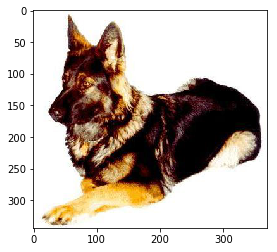

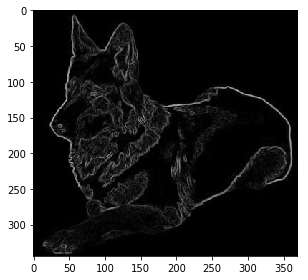

In [8]:
from skimage.feature import hog

plt.imshow(train_set[275][0])
plt.show()

image = train_set[275][0]
edges = filters.sobel(image[:,:,1])
io.imshow(edges)
io.show()

# x = hog(image[:,:,1], orientations=8, pixels_per_cell=(16, 16),
#                     cells_per_block=(1, 1))

# print(len(x))
# plt.show(hog_image)


In [9]:
# Create a classifier: 
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier object
classifier = RandomForestClassifier(n_estimators=50)

# fit the classification model on training set
classifier.fit(Xtrain, Ytrain)

# make predictions for testing set
pred_rf = classifier.predict(Xtest) 


Zero-One Loss: 0.832061068702
Zero-One Score: 0.167938931298
Confusion Matrix:
[i, j] is the # of objects truly in group i but predicted to be in group j


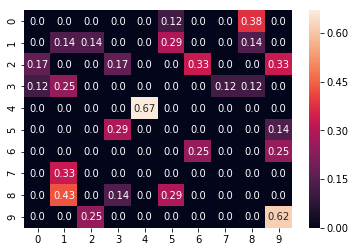

In [10]:
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Ytest, pred_rf) # zero-one loss
rf_01_score = metrics.accuracy_score(Ytest, pred_rf) # zero-one score
cm = metrics.confusion_matrix(Ytest, pred_rf) # conf mat
rf_confmat = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")

import seaborn as sns

sns.heatmap(np.around(rf_confmat[:10,:10],2), annot=True,  fmt='', 
            xticklabels=[str(x) for x in range(10)], yticklabels=[str(x) for x in range(10)]);

In [11]:
rf_precision = metrics.precision_score(Ytest, pred_rf,average="weighted") # TP / (TP + FP)
rf_recall = metrics.recall_score(Ytest, pred_rf,average="weighted") # TP / (TP + FN)

print("Avg. Precision: ",rf_precision)
print("Avg. Recall: ", rf_recall)

Avg. Precision:  0.173197625106
Avg. Recall:  0.167938931298


In [12]:
classifier.feature_importances_

array([ 0.0856924 ,  0.0816932 ,  0.0804166 ,  0.08919156,  0.09755277,
        0.09223288,  0.0887798 ,  0.08425894,  0.08532122,  0.07168529,
        0.07051108,  0.07266427])

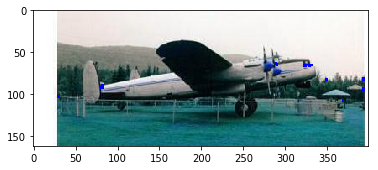

In [42]:
import cv2
import numpy as np

filename = '50_categories/airplanes/airplanes_0011.jpg'
img = cv2.imread(filename)
# gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# gray = np.float32(gray)
dst = cv2.cornerHarris(img[:,:,0],4,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.5*dst.max()]=[0,0,255]

plt.imshow(img)
